In [ ]:
import pandas as pd
import os
import shutil

data = pd.read_csv('vn_celeb_face_recognition/train.csv')

In [ ]:
label_ = list(data['label'])
label = list(set(list(data['label'])))

In [ ]:
list_celeb = os.listdir('data/train')
cnt = 0
for i in label:
#     if label_.count(i) > 8:
    if i not in list_celeb:
        dst = 'celeb/test/' + str(i)
#         dst_ = 'celeb/test/' + str(i)
        os.mkdir(dst)
#         os.mkdir(dst_)
        d = list(data[data['label'] == i]['image'])
        for j in range(len(d)):
#             if j < 3 :
#                 src = 'vn_celeb_face_recognition/train/' + d[j]
#                 shutil.move(src, dst_)
#             else:
                src = 'vn_celeb_face_recognition/train/' + d[j]
                shutil.move(src, dst)
        cnt += 1
        if cnt > 100:
            break

In [ ]:
# Test

In [1]:
# from mtcnn.mtcnn import MTCNN
from numpy import savez_compressed

from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
import pickle
from utils import *
import joblib
from matplotlib import pyplot
import os
import torch

from facenet_pytorch import MTCNN
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

detector = MTCNN(margin=40, device=device, post_process=False)

# #crops the faces
# mtcnn = MTCNN()

In [2]:
# load tfl model
tfl_file = "facenet.tflite"
model = load_tflite_model(tfl_file)
print('Loaded Model')

Loaded Model


In [3]:
path = 'data_test/train/BillGates/Bill_Gates_0000.jpg'

def acc(path, model):
    img = read_image(path)
    face = pre_process(detector, img)

    # convert each face in the train set to an embedding
    embedding = predict(model, face)
    embedding = asarray([embedding])

    # normalize input vectors
    in_encoder = Normalizer(norm='l2')
    out_encoder = LabelEncoder()
    file = open("class.obj",'rb')
    out_encoder = pickle.load(file)
    file.close()

    embedding = in_encoder.transform(embedding)

    filename = 'classifer_model.sav'
    # load the model from disk
    model = joblib.load(filename)
    yhat_class = model.predict(embedding)
    yhat_prob = model.predict_proba(embedding)
    class_index = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    return class_probability

In [4]:
import time
path_true = 'data/train'
path_false = 'celeb/test'
match = []
start = time.time()
cnt = 0
for i in os.listdir(path_true):
    for j in os.listdir(os.path.join(path_true, i)):
        path = os.path.join(path_true, i, j)
        match.append(acc(path, model))
        cnt+=1
end = time.time()
ti = (end - start)/cnt
print(ti)
un_match = []
for i in os.listdir(path_false):
    for j in os.listdir(os.path.join(path_false, i)):
        try:
            path = os.path.join(path_false, i, j)
            un_match.append(acc(path, model))
        except:
            continue

0.27324093346084866


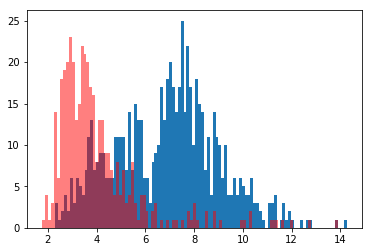

In [5]:
import matplotlib.pyplot as plt
_,_,_=plt.hist(match,bins=100)
_,_,_=plt.hist(un_match,bins=100,fc=(1, 0, 0, 0.5))

plt.show()